In [1]:
# Funckja korelacji dla zaszumionych sygnałów o krótkim czasie trwania

# Domena cząstotliwości

import numpy as np
import math
from scipy import signal
import seaborn as sns
import cmath as cm
import matplotlib.pyplot as plt

sampleRate = 512
timeRange = 10 * 60 # s (długość sygnału czasowego)


timeNum = timeRange * sampleRate
freqNum = int ( timeRange/2 * sampleRate + 1 )  # liczba punktów na wykresie (w domenie częstotliwości) +1 wynika z tego, że wykres zaczyna się od 0 Hz
freqRange = sampleRate/2
freqScale = (freqNum-1)/freqRange

timeLine = np.linspace(0, timeRange, timeNum) # oś czasu
freq = np.linspace(0, freqRange, freqNum) # oś częstotliwości 

spec = np.zeros((3,freqNum)) # deklaracja trzech pustych tablic (dla każdego sygnału)
freqSig = np.zeros((3,freqNum), dtype = complex) # deklaracja tablicy (analogicznie do spec)
timeSig = np.zeros((3,timeNum))
freqCut = np.zeros(3) # tablica częstotliwości odcięcia


            
# modyfikacja funkcji specgram (więcej w pliku my_specgram):
# DO POPRAWY: nauczyć się samodzielnie robić moduły i zrobić osobny moduł myspecgram, 
# który można przywołać w innym notebooku

from matplotlib import *
from pylab import *
def my_specgram(x, NFFT=256, Fs=2, Fc=0, detrend=mlab.detrend_none,
             window=mlab.window_hanning, noverlap=128,
             cmap=None, xextent=None, pad_to=None, sides='default',
             scale_by_freq=None, minfreq = None, maxfreq = None, **kwargs):
    
    ax = gca() # gca = current axis
    Pxx, freqs, bins = mlab.specgram(x, NFFT, Fs, detrend,
         window, noverlap, pad_to, sides, scale_by_freq)

    # modified here
    #####################################
    if minfreq is not None and maxfreq is not None:
        Pxx = Pxx[(freqs >= minfreq) & (freqs <= maxfreq)]
        freqs = freqs[(freqs >= minfreq) & (freqs <= maxfreq)]
    #####################################

    Z = 10. * np.log10(Pxx)
    Z = np.flipud(Z)

    if xextent is None: xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    freqs += Fc
    extent = xmin, xmax, freqs[0], freqs[-1]
    im = ax.imshow(Z, cmap, extent=extent, **kwargs)
    ax.axis('auto')

    return Pxx, freqs, bins, im

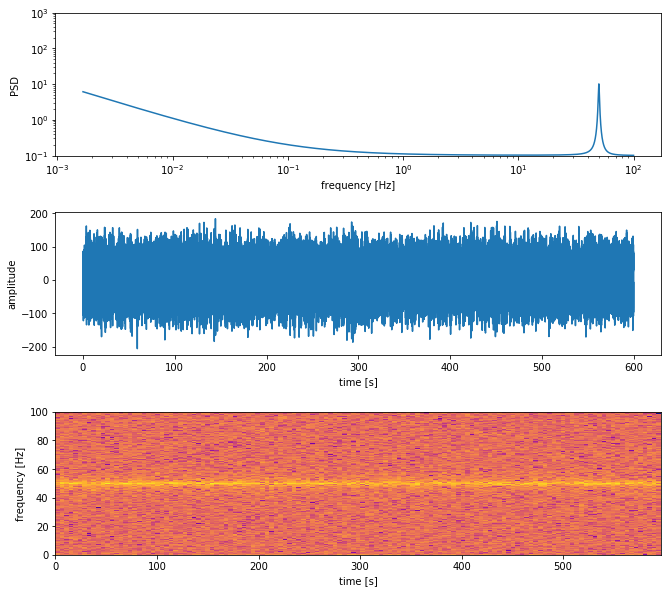

In [2]:
# Pierwszy sygnał

s = 0 # numer sygnału

freqCut[s] = 100 # Hz (częstotliwość odcięcia)
noiseFloor = 0.1 
pinkNoiseAmp = 0.01

cut = int(freqCut[s] * freqScale)
spec[s] = np.array(spec[s]) # spec = spectrum, deklaracja pustej tablicy N-elementowej

for i in range(1,cut,1):
    spec[s][i] = noiseFloor + pinkNoiseAmp / freq[i] # + np.random.normal(1, 0.1) #szum 1/f + szum biały

    
# dodanie szumu na częstotliwości 50 Hz (o kształcie lorentzianu) 
# UWAGA: faza amplitudy zespolonej, która składa się na ten sygnał zostanie wylosowana 
# oznacza to utratę kontroli nad generowanym sygnałem czasowym

#spec[s][ int( 50 * sampleRate) ] = 100 - stosowane wcześniej zamiast lorentzianu

lorWidth = 150 # szerokość funkcji (jednostka: Hz)
lorAmp = 10 # amplituda funkcji
gamma = 0.5 # parametr funkcji
position = 50 * freqScale # pozycja środka dodawanego sygnału

x = np.linspace(0, lorWidth, int(lorWidth*freqScale)) # oś czasu
lor = lorAmp / (1 + np.power((x-lorWidth/2)/gamma,2))
for i in range(int(position - x.size/2), int(position + x.size/2),1):
    if i < cut and i >= 0:
        spec[s][i] = spec[s][i] + lor[i - int((position - x.size/2))]

# zespolona amplituda szumu w domenie częstotliwości (z losowo nadanymi fazami) 
# freqSig1 zawiera pełną informację o sygnale
freqSig[s] = np.sqrt(spec[s])/2 + 0*1j # amplituda sygnału - pierwiastek z mocy (liczba zespolona)
for i in range(freqNum):
    freqSig[s][i] = freqSig[s][i] * np.exp(1j * 2*np.pi * np.random.uniform(0,1)) # nadaję losową fazę amplitudzie 


# można próbować dodać funkcję zespoloną w funkcji częstotliwości, która odpowiada jakiemuś sygnałowi czasowemu

#lorWidth = 150 # szerokość funkcji (jednostka: Hz)
#lorAmp = 10 # amplituda funkcji
#gamma = 0.5 # parametr funkcji
#position = 50 * sampleRate # pozycja środka dodawanego sygnału

#x = np.linspace(0, lorWidth, lorWidth*sampleRate) # oś czasu
# wariant z sygnałem w fazie i w kwadraturze
#lor = np.cos(2*np.pi/lorWidth* (x-lorWidth/2))*np.sqrt(lorAmp * 0.5 / (1 + np.power((x-lorWidth/2)/gamma,2))) + 1j*np.sin(2*np.pi/lorWidth* (x-lorWidth/2))*np.sqrt(lorAmp * 0.5 / (1 + np.power((x-lorWidth/2)/gamma,2)))
# wariant bez części urojonej
#lor = np.sqrt(lorAmp / (1 + np.power((x-lorWidth/2)/gamma,2)))
#for i in range(int(position - x.size/2), int(position + x.size/2),1):
#    freqSig[s][i] = freqSig[s][i] + lor[i - int((position - x.size/2))]
    
    
# odwrotna FFT - przejście do domeny czasu

timeSig[s] = (freqNum-1)*np.fft.irfft(freqSig[s]).real

# można też dodać przebieg czasowy w tym miejscu

#lorWidth = 10 # szerokość funkcji (jednostka: s)
#lorAmp = 100 # amplituda funkcji
#gamma = 0.5 # parametr funkcji
#position = 50 * sampleRate # pozycja środka dodawanego sygnału

#x = np.linspace(0, lorWidth, lorWidth*sampleRate) # oś czasu
#lor = lorAmp / (1 + np.power((x-lorWidth/2)/gamma,2))
#for i in range(int(position - x.size/2), int(position + x.size/2),1):
 #   if i < cut and i >= 0:
  #      timeSig[s][i] = timeSig[s][i] + lor[i - int((position - x.size/2))]


# powrót do domeny częstotliwości        

freqSig[s] = np.fft.rfft(timeSig[s])/(freqNum-1)
spec[s] = np.power(2*abs(freqSig[s]),2)
    
    
# wykres

#PSD
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(freq[1:cut], spec[s][1:cut])
ax1.set(yscale = 'log', xscale = 'log',xlabel = "frequency [Hz]", ylabel = "PSD", ylim = (0.1,1000))

# przebieg czasowy
ax2.plot(timeLine, timeSig[s])
ax2.set(xlabel = "time [s]", ylabel = "amplitude")

# spektrogram
Pxx, freqs, bins, im = my_specgram(timeSig[s], NFFT=int(5 * sampleRate), 
                                       Fs=sampleRate, noverlap=int(sampleRate/2), 
                                       cmap = 'plasma',
                                       minfreq = 0, maxfreq = freqCut[s])
ax3.set(xlabel = "time [s]", ylabel = "frequency [Hz]", ylim = (0,freqCut[s]))

# ustawienia wykresu
fig.tight_layout(pad = -1) # rozsunięcie wykresów, żeby zmieściły się podpisy pod osiami
fig.set_figheight(8)
fig.set_figwidth(9)
plt.show()

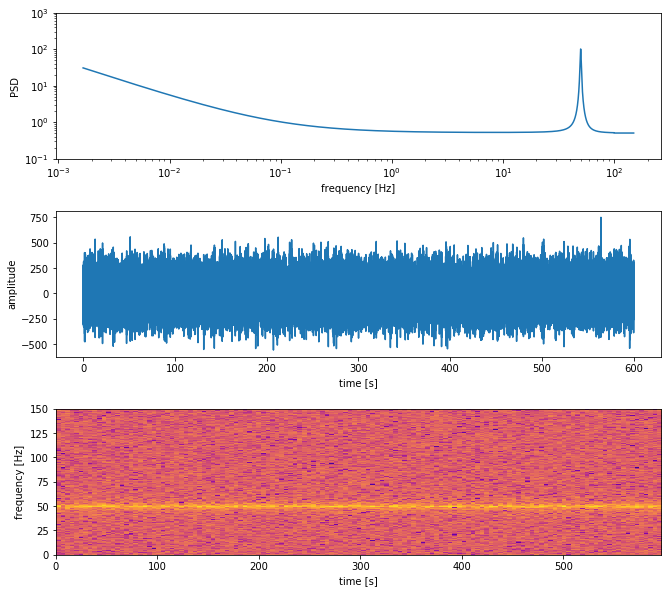

In [3]:
# Drugi sygnał 
s = 1

freqCut[s] = 150 # Hz (częstotliwość odcięcia)
noiseFloor = 0.5 
pinkNoiseAmp = 0.05

cut = int(freqCut[s] * freqScale)
spec[s] = np.array(spec[s]) # spec = spectrum, deklaracja pustej tablicy N-elementowej

for i in range(1,cut,1):
    spec[s][i] = noiseFloor + pinkNoiseAmp / freq[i] # + np.random.normal(1, 0.1) #szum 1/f + szum biały

    
# dodanie szumu na częstotliwości 50 Hz (o kształcie lorentzianu)

#spec[s][ int( 50 * freqScale) ] = 5000

lorWidth = 100 # szerokość funkcji (jednostka: Hz)
lorAmp = 100 # amplituda funkcji
gamma = 0.5 # parametr funkcji
position = 50 * freqScale # pozycja środka dodawanego sygnału

x = np.linspace(0, lorWidth, lorWidth*freqScale) # oś czasu
lor = lorAmp / (1 + np.power((x-lorWidth/2)/gamma,2))
for i in range(int(position - x.size/2), int(position + x.size/2),1):
    if i < cut and i >= 0:
        spec[s][i] = spec[s][i] + lor[i - int((position - x.size/2))]


# zespolona amplituda szumu w domenie częstotliwości (z losowo nadanymi fazami) 
# freqSig1 zawiera pełną informację o sygnale
freqSig[s] = np.sqrt(spec[s])/2 + 0*1j # amplituda sygnału - pierwiastek z mocy (liczba zespolona)
for i in range(freqNum):
    freqSig[s][i] = freqSig[s][i] * np.exp(1j * 2*np.pi * np.random.uniform(0,1)) # nadaję losową fazę amplitudzie 


# można próbować dodać funkcję zespoloną w funkcji częstotliwości, która odpowiada jakiemuś sygnałowi czasowemu
    


# odwrotna FFT - przejście do domeny czasu

timeSig[s] = (freqNum-1)*np.fft.irfft(freqSig[s]).real

# można też dodać przebieg czasowy w tym miejscu


# powrót do domeny częstotliwości        

freqSig[s] = np.fft.rfft(timeSig[s])/(freqNum-1)
spec[s] = np.power(2*abs(freqSig[s]),2)
    
    
# wykres

#PSD
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(freq[1:cut], spec[s][1:cut])
ax1.set(yscale = 'log', xscale = 'log',xlabel = "frequency [Hz]", ylabel = "PSD", ylim = (0.1,1000))

# przebieg czasowy
ax2.plot(timeLine, timeSig[s])
ax2.set(xlabel = "time [s]", ylabel = "amplitude")

# spektrogram
Pxx, freqs, bins, im = my_specgram(timeSig[s], NFFT=int(5 * sampleRate), 
                                Fs=sampleRate, noverlap=int(sampleRate/2), 
                                cmap = 'plasma',
                                minfreq = 0, maxfreq = freqCut[s])
ax3.set(xlabel = "time [s]", ylabel = "frequency [Hz]", ylim = (0,freqCut[s]))

# ustawienia wykresu
fig.tight_layout(pad = -1) # rozsunięcie wykresów, żeby zmieściły się podpisy pod osiami
fig.set_figheight(8)
fig.set_figwidth(9)
plt.show()

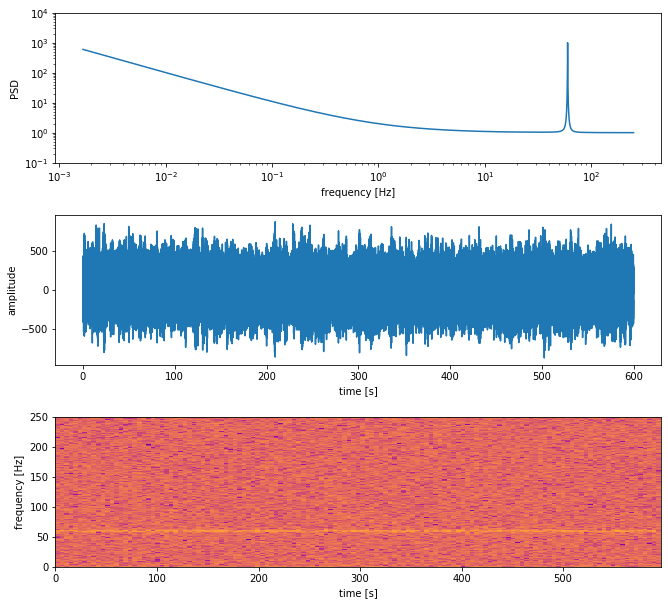

In [92]:
# Trzeci sygnał
s=2

freqCut[s] = 250 # Hz (częstotliwość odcięcia)
noiseFloor = 1 
pinkNoiseAmp = 1

cut = int(freqCut[s] * freqScale)
spec[s] = np.array(spec[s]) # spec = spectrum, deklaracja pustej tablicy N-elementowej

for i in range(1,cut,1):
    spec[s][i] = noiseFloor + pinkNoiseAmp / freq[i] # + np.random.normal(1, 0.1) #szum 1/f + szum biały

    
# dodanie szumu na częstotliwości 60 Hz (o kształcie lorentzianu)

#spec[s][ int( 60 * freqScale) ] = 5000

lorWidth = 100 # szerokość funkcji (jednostka: Hz)
lorAmp = 1000 # amplituda funkcji
gamma = 0.1 # parametr funkcji
position = 60 * freqScale # pozycja środka dodawanego sygnału

x = np.linspace(0, lorWidth, lorWidth*sampleRate) # oś czasu
lor = lorAmp / (1 + np.power((x-lorWidth/2)/gamma,2))
for i in range(int(position - x.size/2), int(position + x.size/2),1):
    if i < cut and i >= 0:
        spec[s][i] = spec[s][i] + lor[i - int((position - x.size/2))]


# zespolona amplituda szumu w domenie częstotliwości (z losowo nadanymi fazami) 
# freqSig zawiera pełną informację o sygnale
freqSig[s] = np.sqrt(spec[s])/2 + 0*1j # amplituda sygnału - pierwiastek z mocy (liczba zespolona)
for i in range(freqNum):
    freqSig[s][i] = freqSig[s][i] * np.exp(1j * 2*np.pi * np.random.uniform(0,1)) # nadaję losową fazę amplitudzie 


# można próbować dodać funkcję zespoloną w funkcji częstotliwości, która odpowiada jakiemuś sygnałowi czasowemu

    

# odwrotna FFT - przejście do domeny czasu

timeSig[s] = (freqNum-1)*np.fft.irfft(freqSig[s]).real

# można też dodać przebieg czasowy w tym miejscu


# powrót do domeny częstotliwości        

freqSig[s] = np.fft.rfft(timeSig[s])/(freqNum-1)
spec[s] = np.power(2*abs(freqSig[s]),2)
    
    
# wykres

#PSD
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(freq[1:cut], spec[s][1:cut])
ax1.set(yscale = 'log', xscale = 'log',xlabel = "frequency [Hz]", ylabel = "PSD", ylim = (0.1,10000))

# przebieg czasowy
ax2.plot(timeLine, timeSig[s])
ax2.set(xlabel = "time [s]", ylabel = "amplitude")

# spektrogram
Pxx, freqs, bins, im = my_specgram(timeSig[s], NFFT=int(5 * sampleRate), 
                                    Fs=sampleRate, noverlap=int(sampleRate/2), 
                                    cmap = 'plasma',
                                    minfreq = 0, maxfreq = freqCut[s])
ax3.set(xlabel = "time [s]", ylabel = "frequency [Hz]", ylim = (0,freqCut[s]))

# ustawienia wykresu
fig.tight_layout(pad = -1) # rozsunięcie wykresów, żeby zmieściły się podpisy pod osiami
fig.set_figheight(8)
fig.set_figwidth(9)
plt.show()

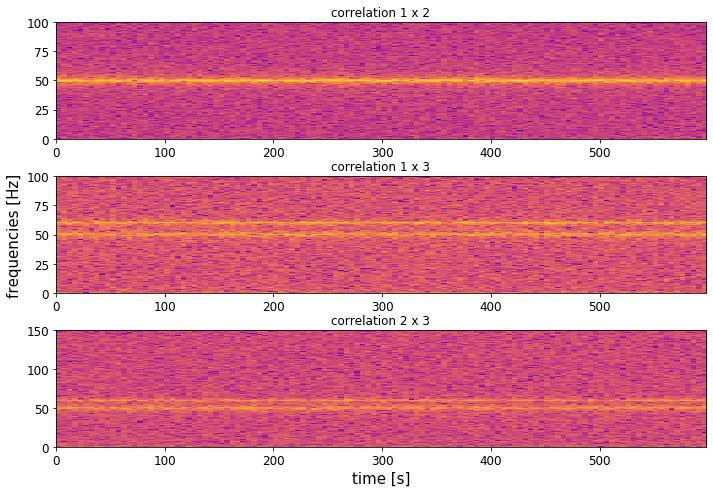

In [93]:
# Macierz korelacji (funkcje korelacji par sygnałów) - korelacje fragmentów sygnałów o zadanych długościach

timeInter = 5 # s - interwał czasowy
over = 5 # s - zachodzenie na siebie segmentów, na razie wersja uproszczona bez zachodzenia
inter = timeInter * sampleRate 
interFreq = int(inter/2)+1 # liczba punktów na wykresie w domenie częstotliwości
num = int(timeRange/timeInter) # liczba "kafli" (interwałów czasowych)

freqSigInterMatrix = np.zeros((3,3,num, interFreq), dtype=complex)
specInterMatrix = np.zeros((3,3,num, interFreq))
timeSigInterMatrix = np.zeros((3,3,num, inter))
timeSigCorr = np.zeros((3,3, num*inter))

fourier = np.zeros((3,int(interFreq)), dtype=complex)
PSD = np.zeros((3,interFreq))

for k in range(0,num,1):
    for i in range(0,3,1):
        fourier[i] = np.fft.rfft(timeSig[i][k*inter:(k+1)*inter]) / (freqNum-1) 
        PSD[i] = np.power(abs(2*fourier[i]),2)
    for i in range(0,3,1):
        for j in range(0,3,1):
            specInterMatrix[i][j][k] = PSD[i] * PSD[j]
            freqSigInterMatrix[i][j][k] = fourier[i] * fourier[j]
            timeSigInterMatrix[i][j][k] = (freqNum-1) * np.fft.irfft(freqSigInterMatrix[i][j][k]).real

for n in range(0,3,1):
    for m in range(0,3,1):
        for i in range(0,num,1):
            for j in range(0, inter,1):
                timeSigCorr[n][m][i*inter + j] = timeSigInterMatrix[n][m][i][j]
            


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

n,m = 0,1
plt.sca(ax1) # set current axis as ax1
Pxx1, freqs1, bins1, im1 = my_specgram(timeSigCorr[n][m], NFFT=int(timeInter * sampleRate),
                                   Fs=sampleRate, noverlap=0, cmap = 'plasma',
                                   minfreq = 0, maxfreq = min(freqCut[n],freqCut[m]))
ax1.set(title = "correlation 1 x 2")
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

n,m = 0,2
plt.sca(ax2)
Pxx2, freqs2, bins2, im2 = my_specgram(timeSigCorr[n][m], NFFT=int(timeInter * sampleRate),
                                   Fs=sampleRate, noverlap=0, cmap = 'plasma',
                                   minfreq = 0, maxfreq = min(freqCut[n],freqCut[m]))
ax2.set_title("correlation 1 x 3")
ax2.set_ylabel("frequencies [Hz]", fontsize = 15)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

n,m = 1,2
plt.sca(ax3)
Pxx3, freqs3, bins3, im3 = my_specgram(timeSigCorr[n][m], NFFT=int(timeInter * sampleRate),
                                   Fs=sampleRate, noverlap=0, cmap = 'plasma',
                                   minfreq = 0, maxfreq = min(freqCut[n],freqCut[m]))
ax3.set_title( "correlation 2 x 3")
ax3.set_xlabel( "time [s]", fontsize=15)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=12)

# ustawienia wykresu
fig.tight_layout(pad = -2.5) # rozsunięcie wykresów, żeby zmieściły się podpisy pod osiami
fig.set_figheight(6)
fig.set_figwidth(9)
plt.show()

In [7]:
# Próba wykreślenia spektrogramu innym sposobem 

#dataTime = np.zeros(interFreq * num)
#dataVal = np.zeros(num*interFreq)

#for i in range(0,num,1):
#    for j in range(0, interFreq,1):
#        dataTime[i*interFreq + j] = timeInter/2 + i*timeInter
#        dataVal[i*interFreq + j] = specInterMatrix[1][1][i][j]
        
#dataFreq = np.zeros(interFreq * num)
#temp = np.linspace(0,freqRange,interFreq)

#for i in range(0,num,1):
#    for j in range(0,interFreq,1):
#        dataFreq[i*interFreq + j] = temp[j]
        
#data = {"time": dataTime, "freq": dataFreq, "val": dataVal }
#import pandas as pd
#df = pd.DataFrame(data)
#df = df.pivot(index = "freq", columns = "time", values = "val")
#sns.heatmap(df)

In [8]:
# Macierz korelacji (funkcje korelacji par sygnałów) - całe przebiegi skorelowane ze sobą
# tylko na próbę, nie zwraca żadnego wykresu

freqSigMatrix = np.zeros((3,3,freqNum), dtype=complex)
specMatrix = np.zeros((3,3,freqNum))
timeSigMatrix = np.zeros((3,3,timeNum)) # korelacje sygnałów

for i in range(0,3,1):
    for j in range(0,3,1):
        freqSigMatrix[i][j] = freqSig[i]*freqSig[j]
        specMatrix[i][j] = spec[i]*spec[j]
        timeSigMatrix[i][j] = (freqNum-1)*np.fft.irfft(freqSigMatrix[i][j])

# Korelacja wszystkich sygnałów na raz

specCorr = spec[0] * spec[1] * spec[2]
freqSigCorr = freqSig[0] * freqSig[1] * freqSig[2]
timeSigCorr = (freqNum-1)*np.fft.irfft(freqSigCorr)